# Lab 04 : VGG architecture - exercise

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import random
from random import randint
import time
import json

import utils

import os
import zipfile
import urllib.request
import shutil

In [4]:
link = "https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/365379/ETHEC_dataset_v0.2.zip?sequence=6&isAllowed=y"


if not os.path.exists('ETHEC_dataset_v0.2.zip'):
    urllib.request.urlretrieve(link, 'ETHEC_dataset_v0.2.zip')
    with zipfile.ZipFile("ETHEC_dataset_v0.2.zip","r") as zip_ref:
        zip_ref.extractall(".")
    os.remove('ETHEC_dataset_v0.2.zip')



In [2]:

class ETHECDataset(Dataset):
    """ Entomological Collection Dataset """

    classes = [
        'Pieridae',
        'Riodinidae',
        'Nymphalidae',
        'Hesperiidae',
        'Papilionidae',
        'Lycaenidae'
    ]

    def __init__(self, root_dir, transform=None, split='train'):
        """
        Args:
            root_dir (string):
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.train = self.split == 'train'

        if self.split == 'train':
            file = 'train.json'
        elif self.split == 'val':
            file = 'val.json'
        else:
            file = 'test.json'

        with open(os.path.join(self.root_dir, 'splits', file)) as f:
            self.train_items = json.load(f)

        # print(list(self.train_items.values())[:3])

        # load the images
        self.images = []
        for key, item in self.train_items.items():
            img_folder = item['image_path']
            img_name = item['image_name']

            # find the label in the list of classes and get its index
            clazz_id = self.classes.index(item['family'])

            # add the image to the list of images
            self.images.append((os.path.join(self.root_dir, 'IMAGO_build_test_resized', img_folder, img_name), clazz_id))

        # shuffle the images
        random.shuffle(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name, clazz_id = self.images[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image, clazz_id

### With or without GPU?

It is recommended to run this code on GPU:<br>
* Time for 1 epoch on CPU : 841 sec (14.02 min)<br>
* Time for 1 epoch on GPU : 9 sec w/ GeForce GTX 1080 Ti <br>

In [3]:
device= torch.device("cuda")
# device= torch.device("cpu")
print(device)

cuda


### Make a VGG convnet class.

In [5]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()


        # block 1:         3 x 224 x 224 --> 64 x 112 x 112
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2, return_indices=True)

        # block 2:         64 x 112 x 112 --> 64 x 56 x 56
        self.conv2a = nn.Conv2d(64,   64,  kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(64,   64,  kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2, 2, return_indices=True)

        # block 3:         64 x 56 x 56 --> 128 x 28 x 28
        self.conv3a = nn.Conv2d(64,   128,  kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(128,   128,  kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2, 2, return_indices=True)

        #block 4:          128 x 28 x 28 --> 16 x 14 x 14
        self.conv4a = nn.Conv2d(128,   16,  kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2, 2, return_indices=True)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(3136, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 6)




    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x,_ = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x,_ = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x,_ = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = F.relu(x)
        x,_ = self.pool4(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 3136)
        x = self.linear1(x)
        x = F.relu(x)
        # x = self.linear2(x)
        # x = F.relu(x)
        x = self.linear3(x)

        return x


    # function to extract patches from an image that activate filters at the k CNN layer
    # the most. The function returns a tensor of size (number_of_filters, number_of_patches, number_of_channels, patch_size, patch_size)
    def extract_patches(self, x, k, number_of_patches=9):
        assert x.shape[0] == 1 # only one image at a time

        all_ops = [
            self.conv1a, F.relu, self.conv1b, F.relu, self.pool1,
            self.conv2a, F.relu, self.conv2b, F.relu, self.pool2,
            self.conv3a, F.relu, self.conv3b, F.relu, self.pool3,
            self.conv4a, F.relu, self.pool4
        ]

        ops = []
        pool_indices = []

        cnt = 0
        for op in all_ops:
            ops.append(op)

            if isinstance(op, nn.Conv2d):
                x = op(x)
                cnt += 1
                if cnt == k:
                    break
            elif isinstance(op, nn.ReLU):
                x = op(x)
            elif isinstance(op, nn.MaxPool2d):
                x, inds = op(x)
                pool_indices.append(inds)


        number_of_filters = ops[-1].out_channels
        # Flatten the spatial dimensions
        flattened = x.view(1, number_of_filters, -1)

        indices = []

        maxvals = []

        # Iterate over each filter to find top 9 activations
        for i in range(number_of_filters):
            # Get the indices of the top 9 activations for this filter
            vals, inds = torch.topk(flattened[0, i], number_of_patches)
            indices.append(inds)
            maxvals.append(-vals.detach().cpu().max())


        assert x.shape[2] * x.shape[3] == flattened.shape[2]

        patches = []
        for i in range(number_of_filters):
            patches.append([])
            for j in range (number_of_patches):

                ind = indices[i][j]
                w, h = (ind // x.shape[2]).item(), (ind % x.shape[3]).item()

                field = [w, w, h, h]

                act_map = torch.zeros_like(x)
                act_map[0, i,  w, h] = x[0, i, w, h]

                pool_ind = -1

                for op in reversed(ops):

                    if isinstance(op, nn.Conv2d):
                        rev_op = nn.ConvTranspose2d(in_channels=op.out_channels,
                                                    out_channels=op.in_channels,
                                                    kernel_size=op.kernel_size,
                                                    stride=op.stride,
                                                    padding=op.padding,
                                                    bias=False,
                                                    device=device)
                        rev_op.weight.data = op.weight.data
                        act_map -= op.bias.view(1, -1, 1, 1)
                        act_map = rev_op(act_map)

                        s = op.stride[0]
                        p = op.padding[0]
                        k = op.kernel_size[0]

                        field = [field[0]*s - p, field[1]*s - p + k - 1,
                                 field[2]*s - p, field[3]*s - p + k - 1]

                    elif isinstance(op, nn.ReLU):
                        act_map = F.relu(act_map, device=device)
                    elif isinstance(op, nn.MaxPool2d):
                        rev_op = nn.MaxUnpool2d(kernel_size=op.kernel_size, stride=op.stride)
                        act_map = rev_op(act_map, pool_indices[pool_ind])
                        pool_ind -= 1

                        field = [field[0]*op.kernel_size, field[1]*op.kernel_size-1,
                                 field[2]*op.kernel_size, field[3]*op.kernel_size-1]


                patch = utils.crop_and_pad(act_map, field[0], field[1], field[2], field[3])

                patches[i].append((patch, field))

            patches = sorted(zip(maxvals, patches))
            patches = [item for key, item in patches]


        return patches



### Build the net. How many parameters in total? (the three layer net had 2 million parameters)

In [18]:

net = VGG_convnet()# COMPLETE HERE
print(net)
utils.display_num_param(net)

VGG_convnet(
  (conv1a): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(128, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=4096, bias=True)
  (linear2): Linear(in_fea

### Send the weights of the networks to the GPU

In [19]:
net = net.to(device)# COMPLETE HERE

### Choose the criterion, batch size, and initial learning rate. Select the following:
* batch size =128
* initial learning rate =0.25


In [20]:
criterion = nn.CrossEntropyLoss()
my_lr=0.015
bs=256    

### Function to evaluate the network on the test set

In [21]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    with torch.no_grad():

        for i,data in enumerate(test_dataloader):

            inputs,labels=data
            inputs=inputs.to(device)
            labels=labels.to(device)

            scores=net(inputs)
            error=utils.get_error(scores,labels)

            running_error += error.item()
            num_batches += 1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

    return total_error

In [22]:

def train(my_lr = my_lr, epochs=20):
    start=time.time()
    
    for epoch in range(1,epochs):
    
        # divide the learning rate by 2 at epoch 10, 14 and 18
        if epoch==10 or epoch==14 or epoch==18:
            my_lr = my_lr / 2# COMPLETE HERE
    
        # create a new optimizer at the beginning of each epoch: give the current learning rate.
        optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )# COMPLETE HERE
    
        # set the running quatities to zero at the beginning of the epoch
        running_loss=0
        running_error=0
        num_batches=0
    
        for i, data in enumerate(train_dataloader, 0):
    
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            scores=net( inputs )
            loss = criterion( scores , labels )
            loss.backward()
    
            optimizer.step()
    
            # print statistics
            running_loss += loss.item()
            error = utils.get_error(scores , labels)
            running_error += error.item()
            num_batches+=1
            elapsed = (time.time()-start)/60
    
    
        # compute error/loss statistics
        total_error = running_error/num_batches
        total_loss = running_loss/num_batches
        print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    
        eval_on_test_set()
        print(' ')



In [23]:
# transforms
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])


# create the dataset
train_dataset = ETHECDataset(root_dir='ETHEC_dataset', transform=transform, split='train')
val_dataset = ETHECDataset(root_dir='ETHEC_dataset', transform=transform, split='val')
test_dataset = ETHECDataset(root_dir='ETHEC_dataset', transform=transform, split='test')

# create the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4)

### Do 20 passes through the training set. Divide the learning rate by 2 at epoch 10, 14 and 18.

In [24]:
train()

epoch= 1 	 time= 1.1565586090087892 min 	 lr= 0.015 	 loss= 1.4508638165213845 	 error= 56.02303605813247 percent
error rate on test set = 56.006163358688354 percent
 
epoch= 2 	 time= 2.4059785048166913 min 	 lr= 0.015 	 loss= 1.4393539862199263 	 error= 55.48632753478897 percent
error rate on test set = 42.06348155674181 percent
 
epoch= 3 	 time= 3.64126398563385 min 	 lr= 0.015 	 loss= 1.267971639032964 	 error= 49.80581577841219 percent
error rate on test set = 54.207121698479895 percent
 
epoch= 4 	 time= 4.864700794219971 min 	 lr= 0.015 	 loss= 0.7320077629772933 	 error= 26.787444886627732 percent
error rate on test set = 19.99991159690054 percent
 
epoch= 5 	 time= 6.088903148969014 min 	 lr= 0.015 	 loss= 0.3919522976958668 	 error= 14.070813680862212 percent
error rate on test set = 22.69316817584791 percent
 
epoch= 6 	 time= 7.309740372498831 min 	 lr= 0.015 	 loss= 1.331953226269542 	 error= 43.96176171469522 percent
error rate on test set = 56.006163358688354 percent
 


### Vizualize filters

In [45]:


def vizualise_at(k=1, input=False, ind=None):

    with torch.no_grad():

        if ind == None:
            ind = randint(0, len(test_dataset))
        minibatch_data, label =  test_dataset[ind]
    
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
    
        inputs = minibatch_data.unsqueeze(0)
    
        patches = net.extract_patches(inputs, k=k, number_of_patches=9)
    
    
    print(patches[0][0][0].shape)
    
    
    if input:
        patches = [[utils.crop_and_pad(minibatch_data.cpu().unsqueeze(0), p[1][0], p[1][1], p[1][2], p[1][3]).squeeze(0) for p in ps] for ps in patches]
        patches = [[torch.clip(p.squeeze(0).permute(1, 2, 0), 0, 1) for p in ps] for ps in patches]
    else:
        patches = [[p[0].squeeze(0).permute(1, 2, 0) for p in ps] for ps in patches]
        patches = [[(p - p.min())/(p.max()-p.min()) for p in ps] for ps in patches]

    
    utils.plot_image_grid_with_borders(patches[:16], grid_shape=(4, 4), patch_border=0.01, grid_border=0.05)

    return ind



torch.Size([1, 3, 38, 38])


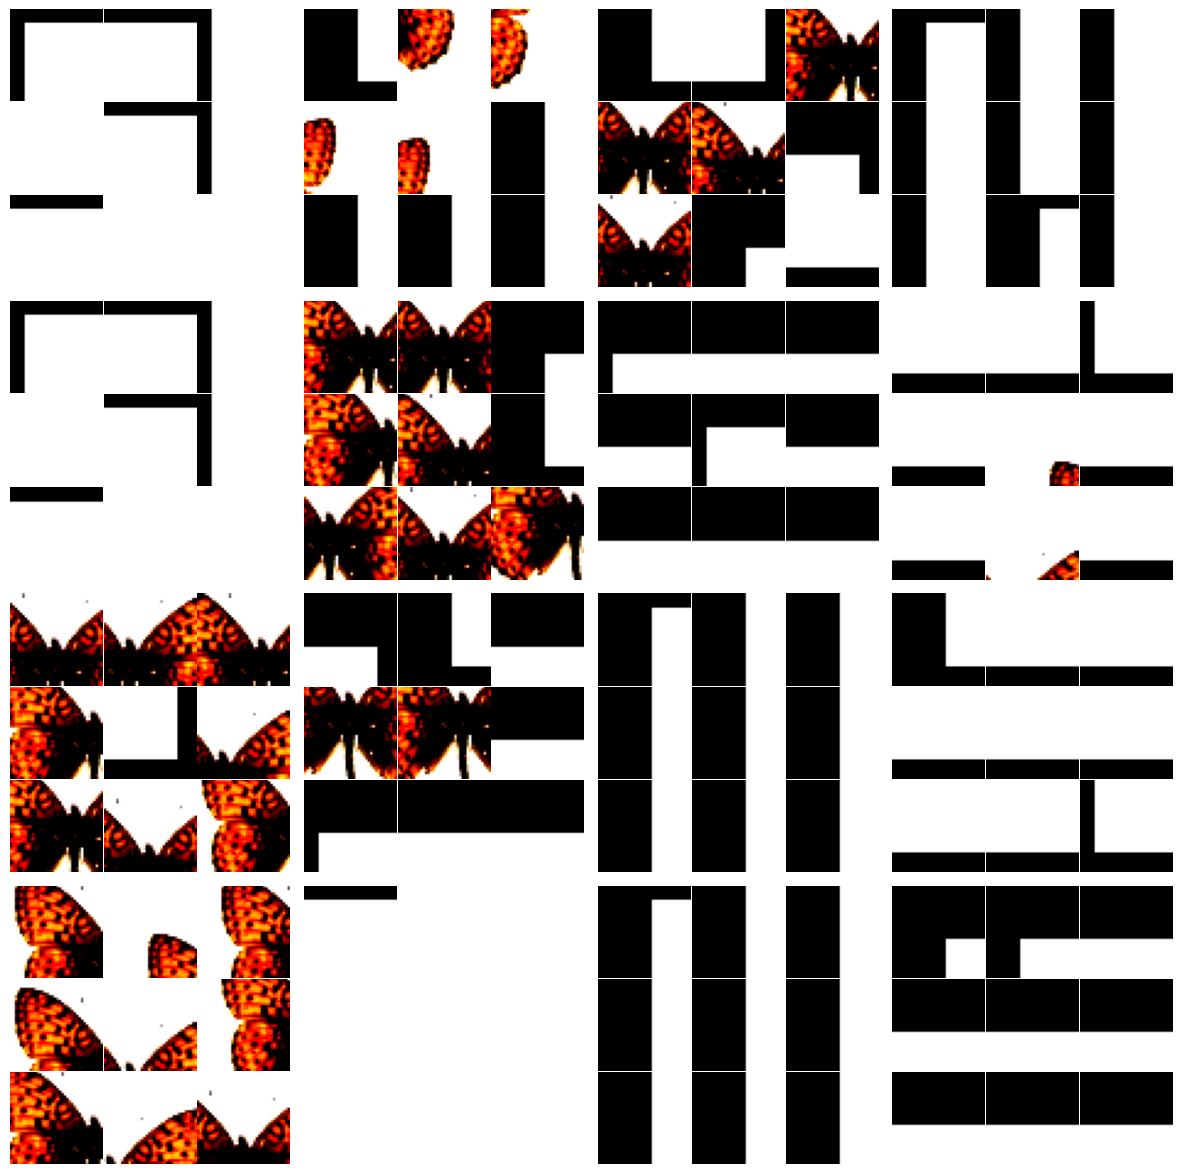

In [57]:
ind = vizualise_at(7, True, ind=51)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


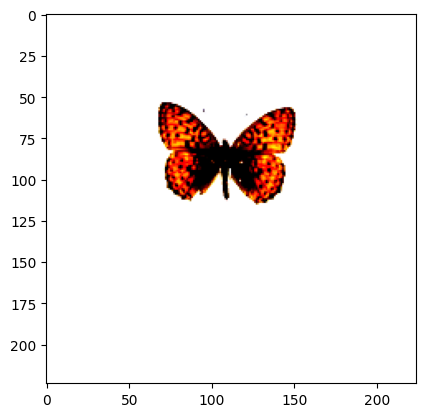

In [52]:
utils.show(test_dataset[ind][0])